# 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import shap

from data_enginerring.targets_set import TARGETS, TargetSet
from data_enginerring.feature_set import STATIC_FEATURES, MICROSTRUCTURE_FEATURES, DeltasFeatureSet


shap.initjs()

SEED = 67
random.seed(SEED)
np.random.seed(SEED)

# 1. Data

## 1. Loading and Pre-processing

In [2]:
dataset_benchmark = pd.read_csv("data/dataset_benchmark.csv", parse_dates=["first_trade_time"])
dataset_expanded = pd.read_csv("data/dataset_expanded.csv", parse_dates=["first_trade_time"])
assert len(dataset_benchmark) == len(dataset_expanded), "Mismatch in tokens included."

def pool_type_identification(x):
    return int(x == "675kPX9MHTjS2zt1qfr1NYHuzeLXfQM9H24wFSUt1Mp8")
dataset_benchmark["pool_type"] = dataset_benchmark["pool_type"].transform(pool_type_identification)
dataset_expanded["pool_type"] = dataset_expanded["pool_type"].transform(pool_type_identification)

dataset_benchmark = dataset_benchmark.sort_values(['first_trade_time', 'token_mint']).set_index('first_trade_time')
dataset_expanded = dataset_expanded.sort_values(['first_trade_time', 'token_mint']).set_index('first_trade_time')

dataset_expanded.head()

,token_mint,pool_type,token_decimals,n_transfers,n_swaps,n_buys,n_lp_addition_like,n_lp_removal_like,buy_percentage,sell_percentage,...,kyle_lambda,roll_spread,roll_percentage_spread,amihud_illiquidity,vpin,md_price_no_post_rc_0.9_0.01,md_price_no_post_rc_0.99_0.005,md_liq_no_post_rc_0.99_0.01,md_liq_0.9,idle_300
first_trade_time,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:31+00:00,3wii3WDRkhScqZvp3q3QvUNPr4w34QF4ydQTbnE5ytKm,1,6,382,381,294,1,0,0.769634,0.227749,...,0.048559,-1802.050086,-7.630116,8.682559e+03,0.516330,1,1,1,1,1
2024-10-01 00:01:13+00:00,HumFbCWH77CiYuwVFV163RYB9Fa7vxqKCCPsz9gspump,1,6,600,599,313,1,0,0.521667,0.476667,...,0.003868,48.157616,0.917897,2.514349e+04,0.427266,1,0,0,0,0
2024-10-01 00:11:09+00:00,2vrTSA71k2JnbT7VdyHqGcyjBNvncHcLPuECPXbUzLkp,1,6,159,158,108,1,0,0.679245,0.314465,...,0.007659,-5827.446046,-88.979381,9.978782e+03,0.997319,0,0,0,0,0
2024-10-01 00:13:18+00:00,7NkeDHRC9ERbZ79ca3hkGvr1UDF2VnAPjNqw81tt4CK5,1,6,627,626,444,1,0,0.708134,0.290271,...,921.830877,-388299.439415,-15.663166,6.692039e+03,0.994968,1,1,1,1,1
2024-10-01 00:14:58+00:00,E7NvJPn2HGvYbqJAKpTNC4spozq9gngQFDkCfVRdkUM6,1,9,729,727,131,1,1,0.179698,0.817558,...,0.005655,-99.042811,NaN,3.668076e+10,0.974120,0,0,1,1,1


In [3]:
meta_columns = ["token_mint", "first_trade_time"]
targets = TargetSet(TARGETS).targets_list
features_benchmark = [c for c in dataset_benchmark.columns if c not in meta_columns + targets]
features_expanded = [c for c in dataset_expanded.columns if c not in meta_columns + targets]

X_bench = dataset_benchmark[features_benchmark]
X_exp = dataset_expanded[features_expanded]
y = dataset_benchmark[targets]

## 1.2. Data Exploration

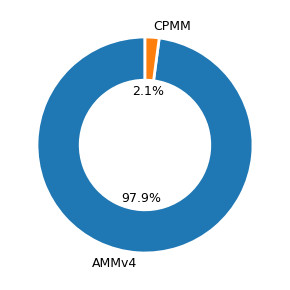

In [4]:
counts = X_bench.groupby("pool_type").pool_type.count().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6, 3))
ax.pie(counts, labels=["AMMv4", "CPMM"],
       autopct="%1.1f%%", pctdistance=0.5, startangle=90,
       wedgeprops=dict(edgecolor="white", linewidth=2, width=0.4),
       textprops=dict(fontsize=9))
plt.tight_layout()
plt.show()

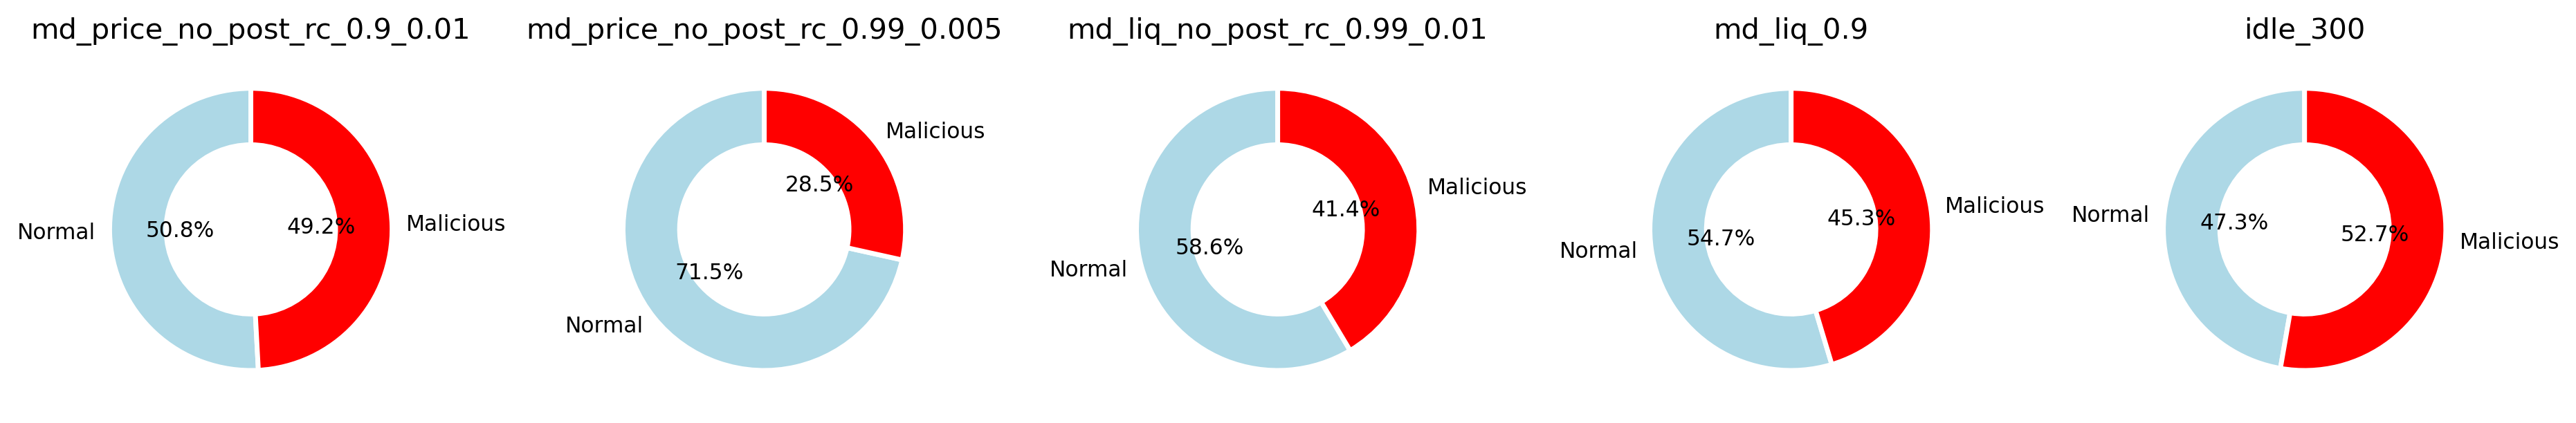

In [14]:
n_targets = len(targets)
fig, ax = plt.subplots(1, n_targets, figsize=(n_targets * 3, 3), dpi=250)

colors = ["lightblue", "red"]
labels = ["Normal", "Malicious"]

for i, target in enumerate(targets):
    counts = y[target].value_counts().sort_index()
    ax[i].pie(counts, labels=labels, colors=colors,
              autopct="%1.1f%%", pctdistance=0.5, startangle=90,            # include percentage
              wedgeprops=dict(edgecolor="white", linewidth=2, width=0.4),   # "donut" plot
              textprops=dict(fontsize=9))
    ax[i].set_title(target)
plt.tight_layout()
plt.show()

# 2. Basic A/B Test: Model with Default Specifications

In [6]:
start_test = '2024-11-01'
train_idx, test_idx = dataset_benchmark.index < start_test, dataset_benchmark.index >= start_test

X_bench_train, X_exp_train, y_train = X_bench[train_idx], X_exp[train_idx], y[train_idx]
X_bench_test, X_exp_test, y_test = X_bench[test_idx], X_exp[test_idx], y[test_idx]
X_exp_train.head()

,pool_type,token_decimals,n_transfers,n_swaps,n_buys,n_lp_addition_like,n_lp_removal_like,buy_percentage,sell_percentage,buy_sell_ratio,...,first_sell_rel_ts,avg_rsi_6,std_rsi_6,avg_rsi_12,std_rsi_12,kyle_lambda,roll_spread,roll_percentage_spread,amihud_illiquidity,vpin
first_trade_time,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:31+00:00,1,6,382,381,294,1,0,0.769634,0.227749,3.379310,...,24.0,54.943875,10.322659,54.146780,5.224459,0.048559,-1802.050086,-7.630116,8.682559e+03,0.516330
2024-10-01 00:01:13+00:00,1,6,600,599,313,1,0,0.521667,0.476667,1.094406,...,2.0,44.483709,19.165070,47.405397,11.957105,0.003868,48.157616,0.917897,2.514349e+04,0.427266
2024-10-01 00:11:09+00:00,1,6,159,158,108,1,0,0.679245,0.314465,2.160000,...,1.0,54.781867,5.880839,58.270899,0.608321,0.007659,-5827.446046,-88.979381,9.978782e+03,0.997319
2024-10-01 00:13:18+00:00,1,6,627,626,444,1,0,0.708134,0.290271,2.439560,...,4.0,49.661232,11.020860,50.070581,5.639549,921.830877,-388299.439415,-15.663166,6.692039e+03,0.994968
2024-10-01 00:14:58+00:00,1,9,729,727,131,1,1,0.179698,0.817558,0.219799,...,42.0,55.626619,28.892618,44.614102,19.053823,0.005655,-99.042811,NaN,3.668076e+10,0.974120


## 2.1. Catboost

Here and futher on the SHAP beeswarm plot is made for the expanded model only.

md_price_no_post_rc_0.9_0.01
[Benchmark]
	ROC AUC	= 0.8701261557427573
	PR AUC	= 0.8757861993525017
	F1	= 0.7808526551982049
[Expanded]
	ROC AUC	= 0.8719941236901582
	PR AUC	= 0.8778202493770668
	F1	= 0.7861481086840704
p-value of difference in:
	ROC AUC	= 0.034886870360715354
	PR AUC	= 0.0246
	F1	= 0.0212


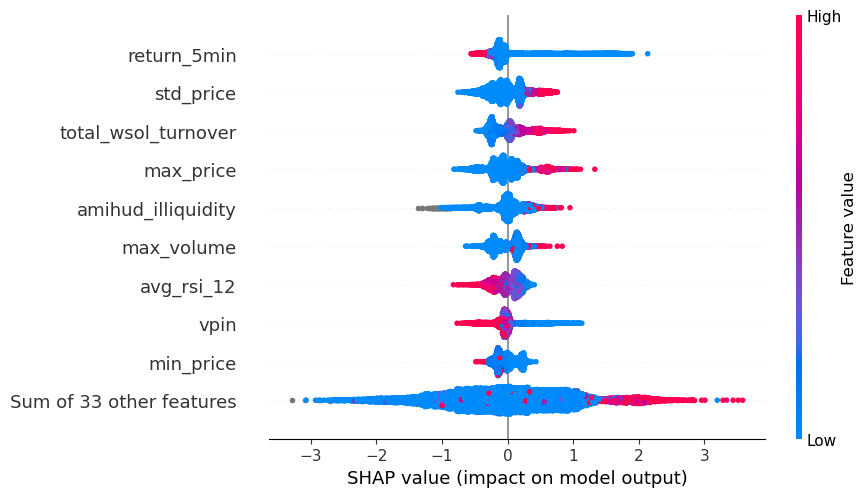

md_price_no_post_rc_0.99_0.005
[Benchmark]
	ROC AUC	= 0.9424880333651731
	PR AUC	= 0.8695975144176519
	F1	= 0.7905697445972495
[Expanded]
	ROC AUC	= 0.9434151411615181
	PR AUC	= 0.8706675219642074
	F1	= 0.7960899315738026
p-value of difference in:
	ROC AUC	= 0.08543555387621588
	PR AUC	= 0.4265
	F1	= 0.0656


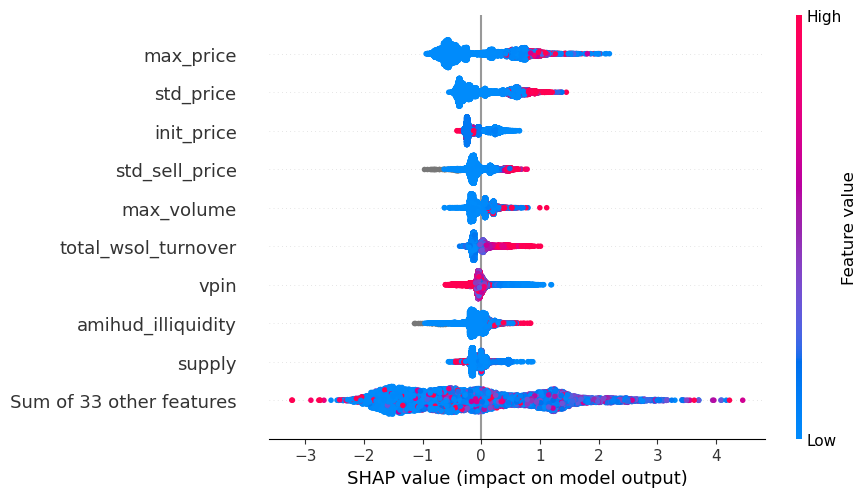

md_liq_no_post_rc_0.99_0.01
[Benchmark]
	ROC AUC	= 0.9695587473152951
	PR AUC	= 0.9479435333044697
	F1	= 0.8709677419354839
[Expanded]
	ROC AUC	= 0.9684696095705193
	PR AUC	= 0.9465977971446324
	F1	= 0.8694958094984702
p-value of difference in:
	ROC AUC	= 0.00416235126085403
	PR AUC	= 0.0476
	F1	= 0.4909


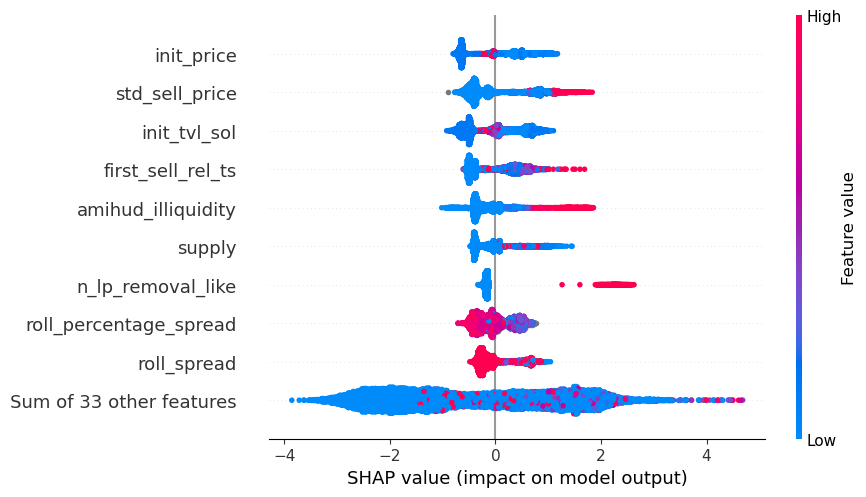

md_liq_0.9
[Benchmark]
	ROC AUC	= 0.9610497598981064
	PR AUC	= 0.9471813666547033
	F1	= 0.8623250152160682
[Expanded]
	ROC AUC	= 0.9606920755295583
	PR AUC	= 0.9468897870798172
	F1	= 0.8591891235736829
p-value of difference in:
	ROC AUC	= 0.3807720650474851
	PR AUC	= 0.6121
	F1	= 0.1467


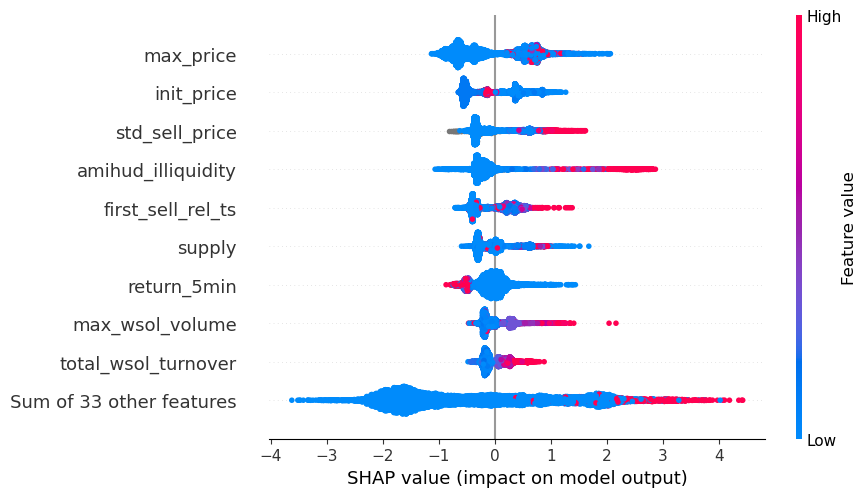

idle_300
[Benchmark]
	ROC AUC	= 0.8983994804283787
	PR AUC	= 0.9030081915973817
	F1	= 0.8117918379624988
[Expanded]
	ROC AUC	= 0.8988219651976426
	PR AUC	= 0.9036750198242123
	F1	= 0.8121735636801929
p-value of difference in:
	ROC AUC	= 0.5184573114452448
	PR AUC	= 0.3347
	F1	= 0.8435


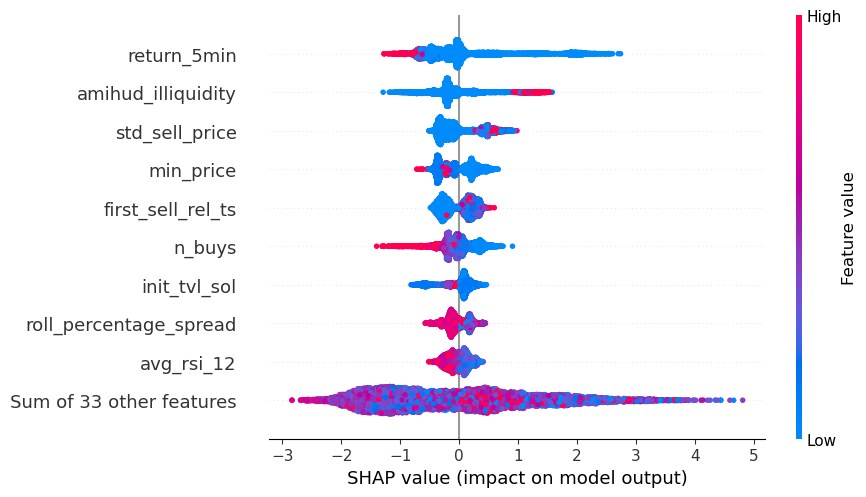

In [ ]:
from utils.catboost_training import cb_train_default
from utils.model_eval import print_metrics, compare_models


for target in targets:
    print(target)

    print("[Benchmark]")
    model_bench, prediction_bench = cb_train_default(
        X_bench_train, X_bench_test, y_train[target], f"bench_{target}", SEED
    )
    print_metrics(y_test[target], prediction_bench)

    print("[Expanded]")
    model_exp, prediction_exp = cb_train_default(
        X_exp_train, X_exp_test, y_train[target], f"exp_{target}", SEED
    )
    print_metrics(y_test[target], prediction_exp)

    compare_models(y_test[target], prediction_bench, prediction_exp, SEED)

    explainer = shap.TreeExplainer(model_exp)
    shap_values = explainer(X_exp_test)
    # shap.plots.beeswarm(shap_values[:,mm_features])
    shap.plots.beeswarm(shap_values)

## 2.2. Random Forest

md_price_no_post_rc_0.9_0.01
[Benchmark]
	ROC AUC	= 0.8603838709677418
	PR AUC	= 0.8641480902302171
	F1	= 0.7788757836574222
[Expanded]
	ROC AUC	= 0.8642180398602836
	PR AUC	= 0.8663756611157909
	F1	= 0.7829234536356862
p-value of difference in:
	ROC AUC	= 0.0011011675121680839
	PR AUC	= 0.1074
	F1	= 0.132


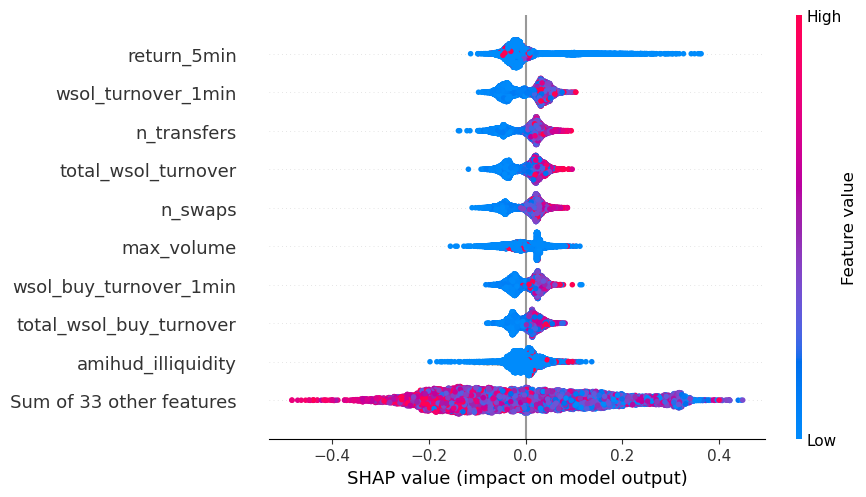

md_price_no_post_rc_0.99_0.005
[Benchmark]
	ROC AUC	= 0.9400473353537282
	PR AUC	= 0.860046948887405
	F1	= 0.7806841046277666
[Expanded]
	ROC AUC	= 0.9408692558079527
	PR AUC	= 0.8606594227660651
	F1	= 0.7755020080321285
p-value of difference in:
	ROC AUC	= 0.3157685657355386
	PR AUC	= 0.7288
	F1	= 0.1488


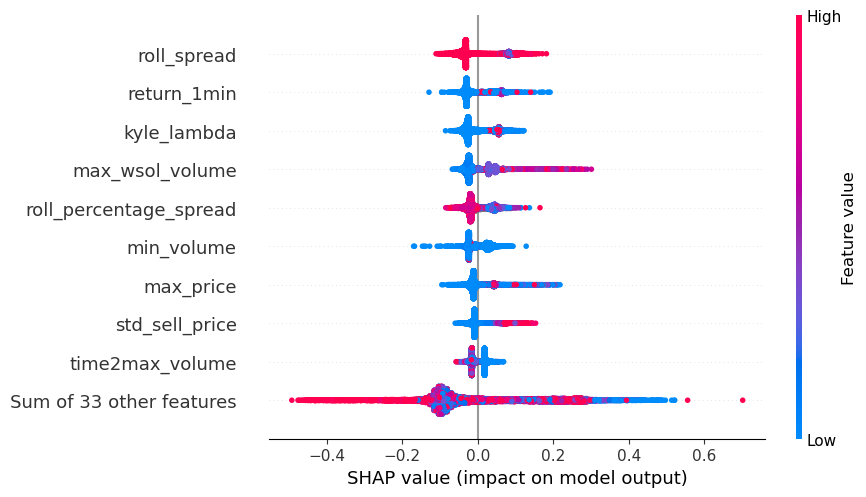

md_liq_no_post_rc_0.99_0.01
[Benchmark]
	ROC AUC	= 0.9673330339043529
	PR AUC	= 0.93833002089644
	F1	= 0.8660991757870558
[Expanded]
	ROC AUC	= 0.9674642685617685
	PR AUC	= 0.93915389319513
	F1	= 0.8658536585365854
p-value of difference in:
	ROC AUC	= 0.7558578279758202
	PR AUC	= 0.5492
	F1	= 0.9244


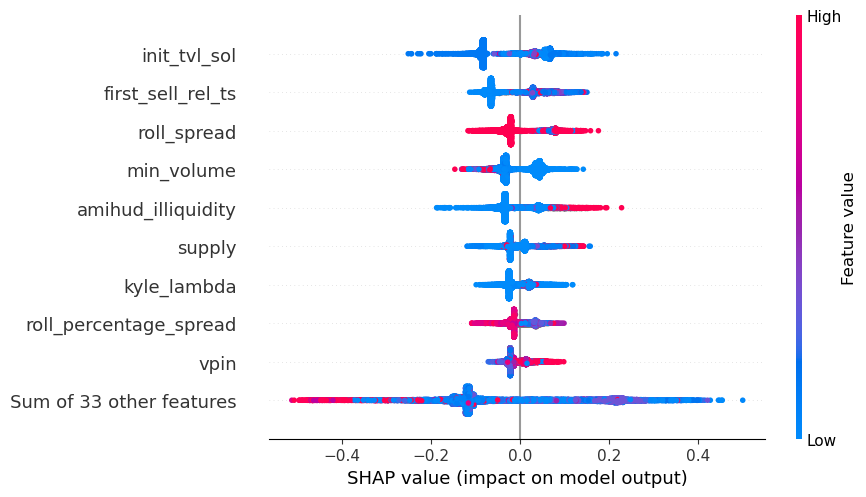

md_liq_0.9
[Benchmark]
	ROC AUC	= 0.9586300841504902
	PR AUC	= 0.940339923176369
	F1	= 0.8596985663521627
[Expanded]
	ROC AUC	= 0.958945488240012
	PR AUC	= 0.9408109833642702
	F1	= 0.86037921694164
p-value of difference in:
	ROC AUC	= 0.5728067106074592
	PR AUC	= 0.6464
	F1	= 0.7822


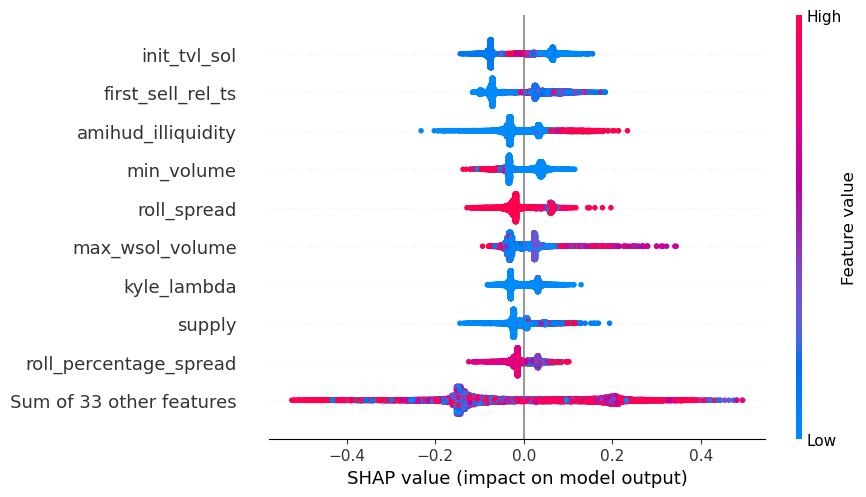

idle_300
[Benchmark]
	ROC AUC	= 0.8935310645876571
	PR AUC	= 0.8965067788106982
	F1	= 0.8118533400301357
[Expanded]
	ROC AUC	= 0.894573285452274
	PR AUC	= 0.898098515446807
	F1	= 0.8120663650075415
p-value of difference in:
	ROC AUC	= 0.23141212157582802
	PR AUC	= 0.1546
	F1	= 0.9173


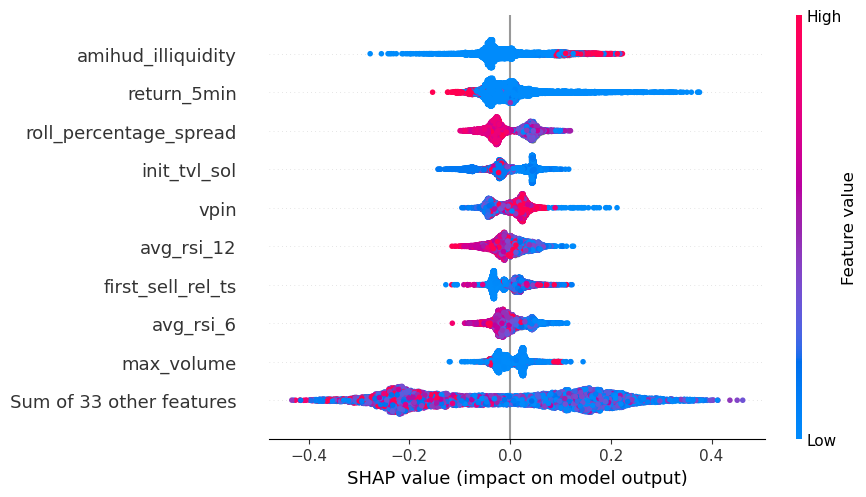

In [ ]:
from utils.forest_training import rf_train_default


for target in targets:
    print(target)

    print("[Benchmark]")
    model_bench, prediction_bench = rf_train_default(
        X_bench_train, X_bench_test, y_train[target], f"bench_{target}", SEED
    )
    print_metrics(y_test[target], prediction_bench)

    print("[Expanded]")
    model_exp, prediction_exp = rf_train_default(
        X_exp_train, X_exp_test, y_train[target], f"exp_{target}", SEED
    )
    print_metrics(y_test[target], prediction_exp)

    compare_models(y_test[target], prediction_bench, prediction_exp, SEED)

    explainer = shap.TreeExplainer(model_exp)
    shap_values = explainer(X_exp_test, approximate=True)
    shap.plots.beeswarm(shap_values[:, :, 1])

# 3. With hyperparameter tuning

## 3.1. Catboost

Training for: md_price_no_post_rc_0.9_0.01
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.8552
Best params: {'iterations': 916, 'depth': 6, 'learning_rate': 0.0196418192390579, 'l2_leaf_reg': 8.277280542157403, 'subsample': 0.770347130345135, 'colsample_bylevel': 0.6199102507175586, 'min_child_samples': 76, 'max_bin': 241, 'random_strength': 3.3362335360911506}
	ROC AUC	= 0.8696074378467229
	PR AUC	= 0.8758214122851375
	F1	= 0.7810701342997228
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.8582
Best params: {'iterations': 1052, 'depth': 7, 'learning_rate': 0.00997920945904863, 'l2_leaf_reg': 3.212785869423501, 'subsample': 0.705882504739105, 'colsample_bylevel': 0.8949162371594787, 'min_child_samples': 56, 'max_bin': 263, 'random_strength': 1.1616145974666232}
	ROC AUC	= 0.872360550647216
	PR AUC	= 0.8784575164802736
	F1	= 0.7850069215206048
p-value of difference in:
	ROC AUC	= 9.123766589970228e-06
	PR AUC	= 0.0
	F1	= 0.0504


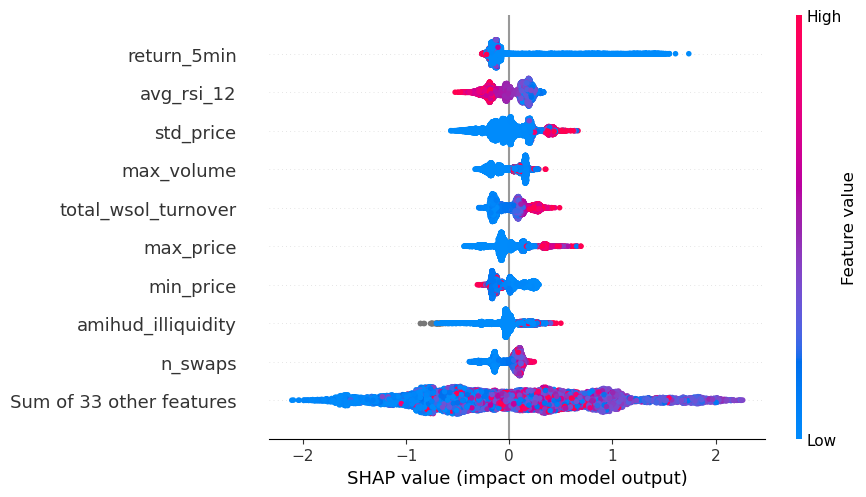

Training for: md_price_no_post_rc_0.99_0.005
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9289
Best params: {'iterations': 1355, 'depth': 5, 'learning_rate': 0.01806090689249255, 'l2_leaf_reg': 4.3166125812008485, 'subsample': 0.6311560446046937, 'colsample_bylevel': 0.7936535614670871, 'min_child_samples': 47, 'max_bin': 430, 'random_strength': 2.5655010541019254}
	ROC AUC	= 0.9428102089669375
	PR AUC	= 0.8712121664849103
	F1	= 0.7914375490966221
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9292
Best params: {'iterations': 1201, 'depth': 6, 'learning_rate': 0.022475144458303734, 'l2_leaf_reg': 3.131512677845638, 'subsample': 0.9650856186189479, 'colsample_bylevel': 0.6377087536826624, 'min_child_samples': 31, 'max_bin': 346, 'random_strength': 9.566634887621442}
	ROC AUC	= 0.9444980354006847
	PR AUC	= 0.8728257304862629
	F1	= 0.7928176795580111
p-value of difference in:
	ROC AUC	= 0.000122476969899964
	PR AUC	= 0.1081
	F1	= 0.6238


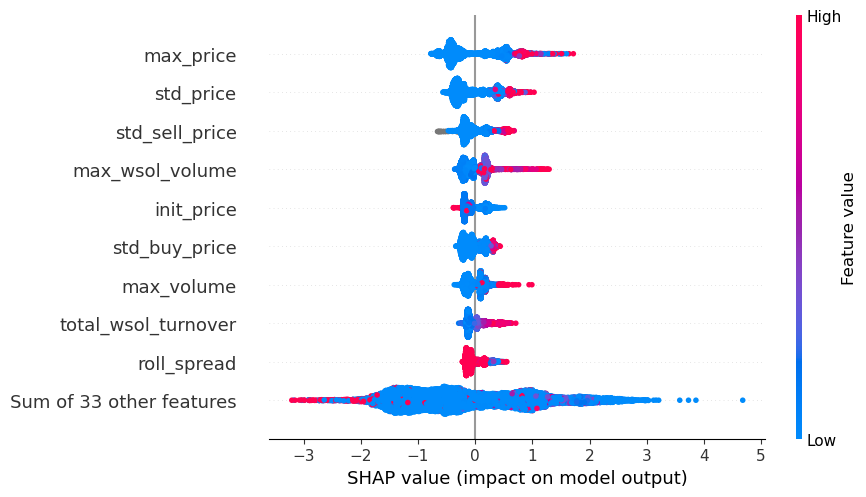

Training for: md_liq_no_post_rc_0.99_0.01
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9576
Best params: {'iterations': 1127, 'depth': 6, 'learning_rate': 0.01630272176917068, 'l2_leaf_reg': 5.141713643386458, 'subsample': 0.5646014455055164, 'colsample_bylevel': 0.5018476212784511, 'min_child_samples': 47, 'max_bin': 32, 'random_strength': 0.1322810029395122}
	ROC AUC	= 0.9704149160652147
	PR AUC	= 0.949581019964144
	F1	= 0.8736386301010366
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9582
Best params: {'iterations': 640, 'depth': 7, 'learning_rate': 0.016916931197124924, 'l2_leaf_reg': 1.8874341220371669, 'subsample': 0.9945490691174941, 'colsample_bylevel': 0.871968617538963, 'min_child_samples': 17, 'max_bin': 448, 'random_strength': 0.6386679024776324}
	ROC AUC	= 0.9699675751475588
	PR AUC	= 0.9491727459796635
	F1	= 0.8727368838377164
p-value of difference in:
	ROC AUC	= 0.2259670288025617
	PR AUC	= 0.5541
	F1	= 0.6238


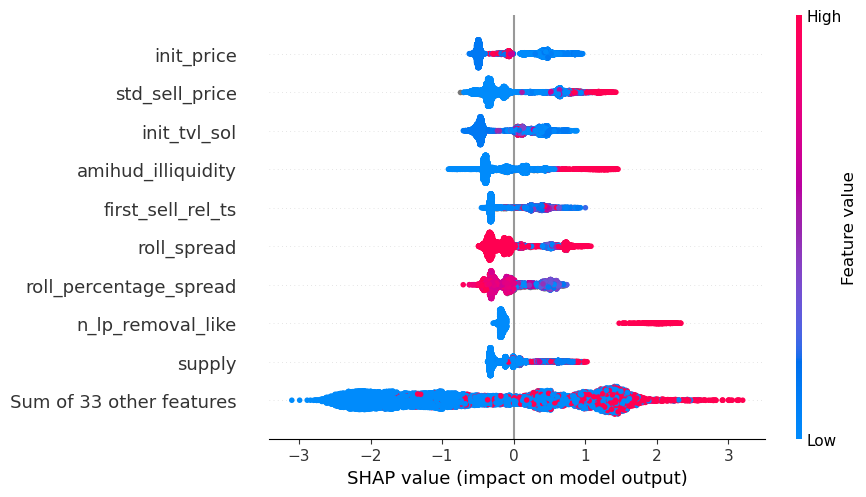

Training for: md_liq_0.9
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9483
Best params: {'iterations': 1388, 'depth': 7, 'learning_rate': 0.01631859730209174, 'l2_leaf_reg': 8.171654141644026, 'subsample': 0.7503958521250517, 'colsample_bylevel': 0.7722436910227772, 'min_child_samples': 50, 'max_bin': 384, 'random_strength': 0.7843182519430164}
	ROC AUC	= 0.9614242969481535
	PR AUC	= 0.9476301916991957
	F1	= 0.8645720476706392
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9486
Best params: {'iterations': 1494, 'depth': 7, 'learning_rate': 0.007869621848778265, 'l2_leaf_reg': 0.2692373994719627, 'subsample': 0.8268180773963516, 'colsample_bylevel': 0.8514745989148638, 'min_child_samples': 14, 'max_bin': 466, 'random_strength': 1.3289245255826423}
	ROC AUC	= 0.9619915149083406
	PR AUC	= 0.9484662690020118
	F1	= 0.8645595481312343
p-value of difference in:
	ROC AUC	= 0.11647919951634923
	PR AUC	= 0.1342
	F1	= 0.9956


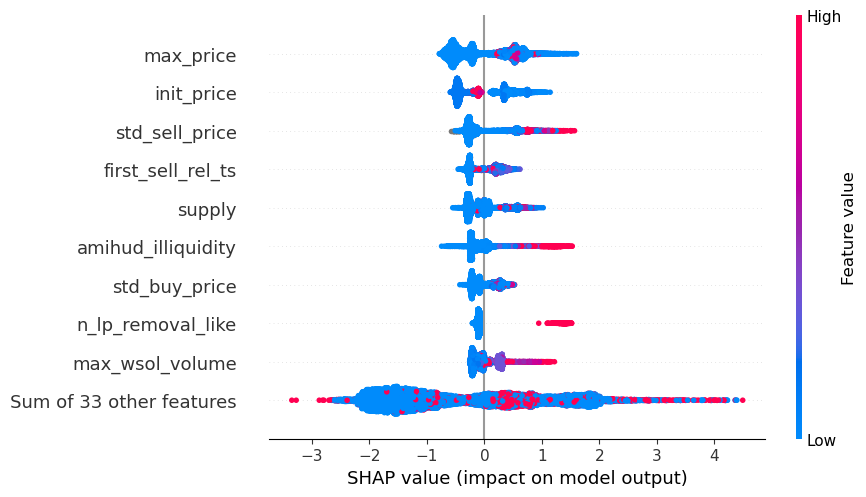

Training for: idle_300
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.8927
Best params: {'iterations': 1494, 'depth': 7, 'learning_rate': 0.008139614144513363, 'l2_leaf_reg': 3.212785869423501, 'subsample': 0.5637643412918795, 'colsample_bylevel': 0.995484227558686, 'min_child_samples': 14, 'max_bin': 389, 'random_strength': 3.4392370721785865}
	ROC AUC	= 0.8972208210618806
	PR AUC	= 0.9030595497681472
	F1	= 0.8116228503656849
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.8940
Best params: {'iterations': 1356, 'depth': 6, 'learning_rate': 0.016154453741445206, 'l2_leaf_reg': 0.6380986515335738, 'subsample': 0.98267940808267, 'colsample_bylevel': 0.9201098084300185, 'min_child_samples': 92, 'max_bin': 416, 'random_strength': 4.9630555584376825}
	ROC AUC	= 0.898950124115687
	PR AUC	= 0.9039445610679854
	F1	= 0.8128171957408697
p-value of difference in:
	ROC AUC	= 0.005711050565692267
	PR AUC	= 0.1567
	F1	= 0.4714


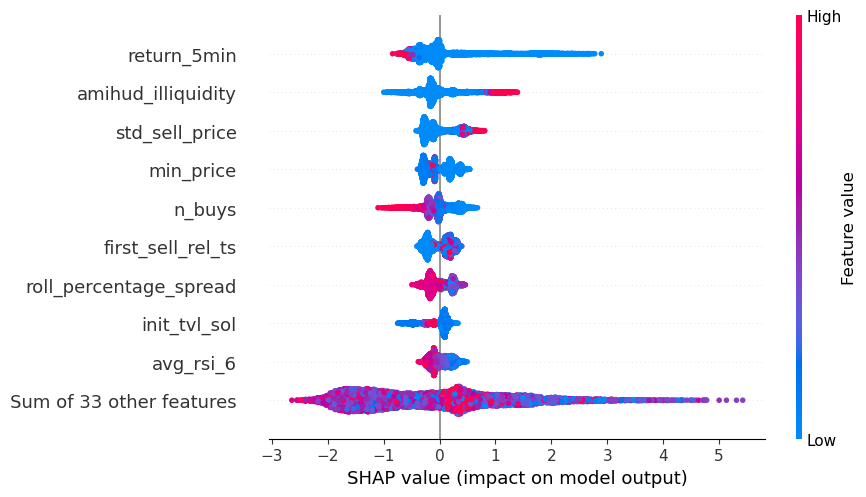

In [9]:
from utils.catboost_training import cb_tune_and_train_standard

for target in targets:
    print(f"Training for: {target}")

    # benchmark
    print("[Benchmark]")
    model_bench, prediction_bench = cb_tune_and_train_standard(
        X_bench_train, X_bench_test, y_train[target], output_file=f"bench_{target}", seed=SEED
    )
    print_metrics(y_test[target], prediction_bench)

    # expanded
    print("[Expanded]")
    model_exp, prediction_exp = cb_tune_and_train_standard(
        X_exp_train, X_exp_test, y_train[target], output_file=f"exp_{target}", seed=SEED
    )
    print_metrics(y_test[target], prediction_exp)

    # statistical significance
    compare_models(y_test[target], prediction_bench, prediction_exp, SEED)

    # shap
    explainer = shap.TreeExplainer(model_exp)
    shap_values = explainer(X_exp_test)
    shap.plots.beeswarm(shap_values)

## 3.2. Random Forest

Training for: md_price_no_post_rc_0.9_0.01
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.8508
Best params: {'n_estimators': 953, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None, 'max_samples': 0.6928863083759531, 'criterion': 'log_loss'}
	ROC AUC	= 0.8650653379905485
	PR AUC	= 0.8714839473259594
	F1	= 0.7784163473818646
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.8543
Best params: {'n_estimators': 369, 'max_depth': 13, 'min_samples_split': 29, 'min_samples_leaf': 5, 'max_features': None, 'max_samples': 0.9217079210555604, 'criterion': 'log_loss'}
	ROC AUC	= 0.8687138689130881
	PR AUC	= 0.8744434791107165
	F1	= 0.7798527371678583
p-value of difference in:
	ROC AUC	= 4.0832068885912665e-05
	PR AUC	= 0.0001
	F1	= 0.5365


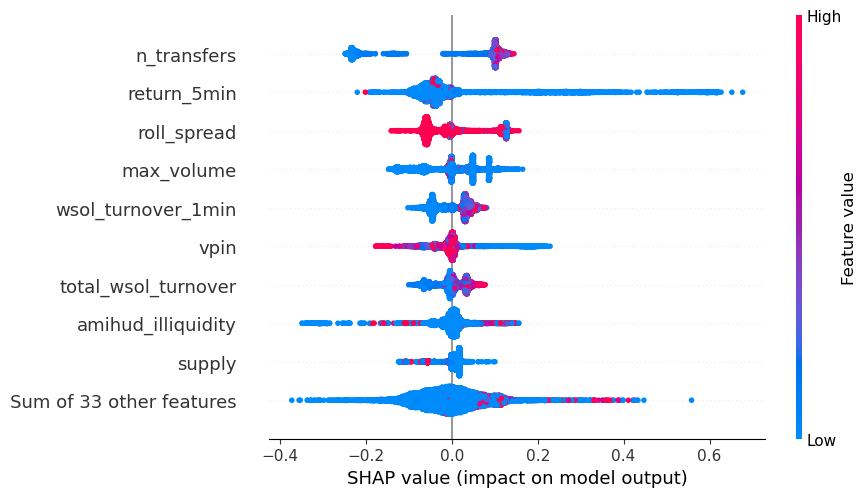

Training for: md_price_no_post_rc_0.99_0.005
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9243
Best params: {'n_estimators': 1225, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_samples': 0.7047942549342237, 'criterion': 'log_loss'}
	ROC AUC	= 0.9425435664030789
	PR AUC	= 0.8662848986126502
	F1	= 0.789464123524069
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9262
Best params: {'n_estimators': 1242, 'max_depth': 10, 'min_samples_split': 28, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_samples': 0.7648054419434482, 'criterion': 'log_loss'}
	ROC AUC	= 0.943355776448974
	PR AUC	= 0.8680770127292501
	F1	= 0.7919096209912536
p-value of difference in:
	ROC AUC	= 0.023607136347690204
	PR AUC	= 0.001
	F1	= 0.2694


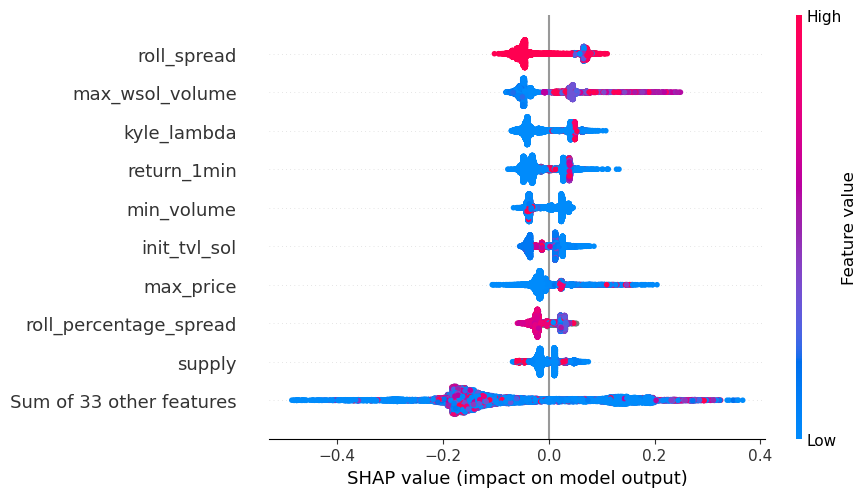

Training for: md_liq_no_post_rc_0.99_0.01
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9566
Best params: {'n_estimators': 1485, 'max_depth': 14, 'min_samples_split': 23, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.8362677303776955, 'criterion': 'log_loss'}
	ROC AUC	= 0.9687716031590576
	PR AUC	= 0.9460462278202085
	F1	= 0.8691650230111768
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9574
Best params: {'n_estimators': 1485, 'max_depth': 14, 'min_samples_split': 23, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': 0.8362677303776955, 'criterion': 'log_loss'}
	ROC AUC	= 0.9687328702501189
	PR AUC	= 0.9459068305350548
	F1	= 0.8700195950359242
p-value of difference in:
	ROC AUC	= 0.9365198531947999
	PR AUC	= 0.8832
	F1	= 0.6711


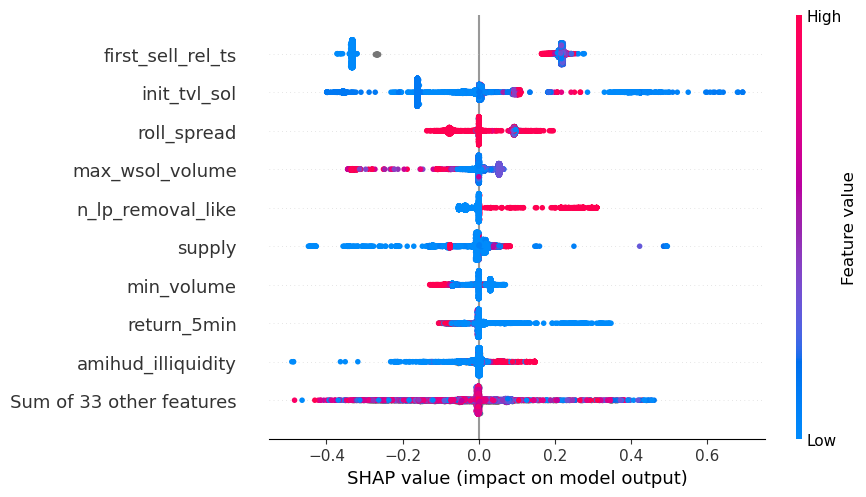

Training for: md_liq_0.9
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9442
Best params: {'n_estimators': 294, 'max_depth': 15, 'min_samples_split': 30, 'min_samples_leaf': 3, 'max_features': None, 'max_samples': 0.9158561079785033, 'criterion': 'log_loss'}
	ROC AUC	= 0.9576211306646553
	PR AUC	= 0.9425238718291575
	F1	= 0.8568693154619436
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.9456
Best params: {'n_estimators': 341, 'max_depth': 14, 'min_samples_split': 42, 'min_samples_leaf': 4, 'max_features': None, 'max_samples': 0.790764897857039, 'criterion': 'log_loss'}
	ROC AUC	= 0.9589253032272843
	PR AUC	= 0.9438961345123859
	F1	= 0.8618586293505561
p-value of difference in:
	ROC AUC	= 0.08571339819483415
	PR AUC	= 0.2112
	F1	= 0.0327


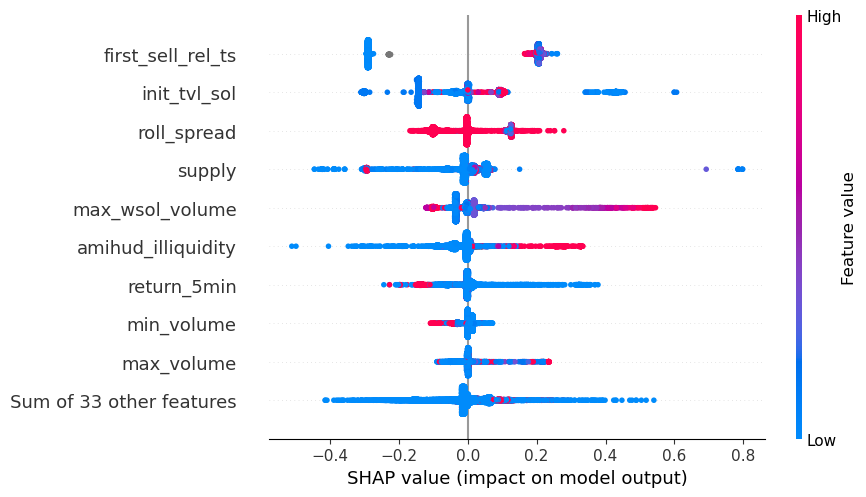

Training for: idle_300
[Benchmark]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.8886
Best params: {'n_estimators': 716, 'max_depth': 30, 'min_samples_split': 32, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_samples': 0.9277802156951758, 'criterion': 'entropy'}
	ROC AUC	= 0.896684230067734
	PR AUC	= 0.9021998841314497
	F1	= 0.8115384615384615
[Expanded]


  0%|          | 0/25 [00:00<?, ?it/s]

Best CV ROC AUC: 0.8896
Best params: {'n_estimators': 665, 'max_depth': 18, 'min_samples_split': 49, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_samples': 0.9847931968864698, 'criterion': 'entropy'}
	ROC AUC	= 0.896510831339248
	PR AUC	= 0.9028107389333444
	F1	= 0.8102366983613191
p-value of difference in:
	ROC AUC	= 0.7156907341732458
	PR AUC	= 0.2901
	F1	= 0.4004


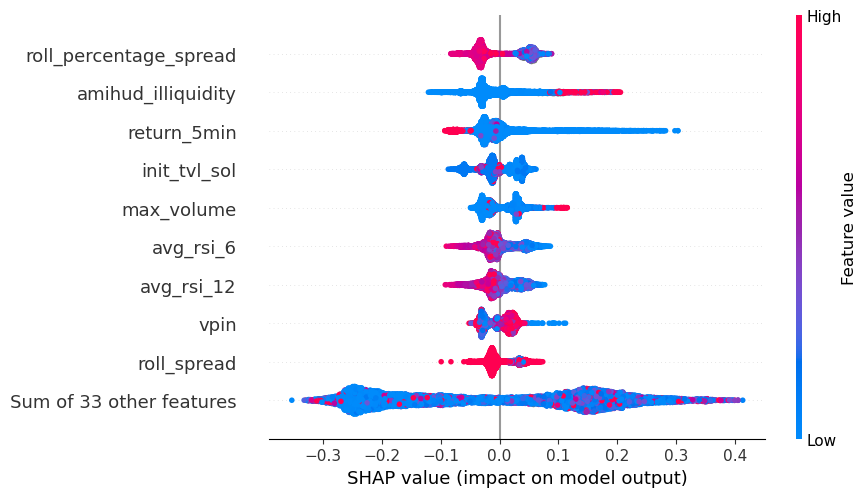

In [ ]:
from utils.forest_training import rf_tune_and_train_standard

for target in targets:
    print(f"Training for: {target}")

    # benchmark
    print("[Benchmark]")
    model_bench, prediction_bench = rf_tune_and_train_standard(
        X_bench_train, X_bench_test, y_train[target], output_file=f"bench_{target}", seed=SEED
    )
    print_metrics(y_test[target], prediction_bench)

    # expanded
    print("[Expanded]")
    model_exp, prediction_exp = rf_tune_and_train_standard(
        X_exp_train, X_exp_test, y_train[target], output_file=f"exp_{target}", seed=SEED
    )
    print_metrics(y_test[target], prediction_exp)

    # statistical significance
    compare_models(y_test[target], prediction_bench, prediction_exp, SEED)

    # shap
    explainer = shap.TreeExplainer(model_exp)
    shap_values = explainer(X_exp_test, approximate=True)
    shap.plots.beeswarm(shap_values[:, :, 1])